<a href="https://colab.research.google.com/github/onlygoodman/dacon_shopping_sales_predict/blob/main/project_shop_shell003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

001 - 기본적인 전처리 및 성능확인

In [236]:
import pandas as pd
import numpy as np
import pandas as pd
from itertools import permutations,combinations
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")


import math #차후 factorial 계산 등 수학적인 계산을 위한 import
from numpy import dot
from numpy.linalg import norm

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.preprocessing import PolynomialFeatures #특성공학을 사용하기 위한 import
from sklearn.preprocessing import StandardScaler #전처리된 데이터들의 scale을 맞춰주기 위한 import
from sklearn.decomposition import PCA #차원 축소 - 주성분의 개수에 따른 최적화 모델 구현을 위한 import


#model
from sklearn.linear_model import LinearRegression

from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
# from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score #이후 test.csv 파일의 predict 자료의 score을 매기기 위한 import

In [237]:
# Train dataset은 Label이 존재하지 않음
train_df = pd.read_csv("/content/drive/MyDrive/shopping_sell_dataset/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/shopping_sell_dataset/test.csv")
submit = pd.read_csv("/content/drive/MyDrive/shopping_sell_dataset/sample_submission.csv")

In [238]:
train_df.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [239]:
#date form change
def datefunc(date):
  d, m ,y = date.split("/")
  return "{}/{}/{}".format(y,m,d)

def monthfunc(date):
  d, m, y = date.split("/")
  return int(m)

def dayfunc(date):
  d, m, y = date.split("/")
  return int(d)

#bool data to one hot encoding
def holiday_to_number(isholiday):
    if isholiday == True:
        number = 1
    else:
        number = 0
    return number

#기존 Date의 형식이 옳지 않아 date값 변경
train_df['Date_new']=train_df['Date'].apply(lambda x: datefunc(x))
test_df['Date_new']=test_df['Date'].apply(lambda x: datefunc(x))  

#기존 Date형식에서 월 columns 추가 -> 차후 월별 매출 등급 부여에 사용
train_df['Month'] = train_df['Date'].apply(lambda x: monthfunc(x))
test_df['Month'] = test_df['Date'].apply(lambda x: monthfunc(x))

#기존 Date형식에서 일 columns 추가 -> 차후 일별 매출 등급 부여에 사용
train_df['Day'] = train_df['Date'].apply(lambda x: dayfunc(x))
test_df['Day'] = test_df['Date'].apply(lambda x: dayfunc(x))

# 이 함수를 IsHoliday 칼럼에 적용한 NumberHoliday 칼럼을 만들어줍니다.
train_df['NumberHoliday'] = train_df['IsHoliday'].apply(holiday_to_number)
test_df['NumberHoliday'] = test_df['IsHoliday'].apply(holiday_to_number)

# data.drop(columns=['ID'])[col]
train_df.drop(columns=['IsHoliday'], inplace = True)
test_df.drop(columns=['IsHoliday'], inplace = True)

train_df.head()
# train_df.to_csv("mydata1.csv")

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,Weekly_Sales,Date_new,Month,Day,NumberHoliday
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,1643690.90,2010/02/05,2,5,0
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,1641957.44,2010/02/12,2,12,1
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,1611968.17,2010/02/19,2,19,0
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,1409727.59,2010/02/26,2,26,0
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,1554806.68,2010/03/05,3,5,0


In [240]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6255 non-null   int64  
 1   Store          6255 non-null   int64  
 2   Date           6255 non-null   object 
 3   Temperature    6255 non-null   float64
 4   Fuel_Price     6255 non-null   float64
 5   Promotion1     2102 non-null   float64
 6   Promotion2     1592 non-null   float64
 7   Promotion3     1885 non-null   float64
 8   Promotion4     1819 non-null   float64
 9   Promotion5     2115 non-null   float64
 10  Unemployment   6255 non-null   float64
 11  Weekly_Sales   6255 non-null   float64
 12  Date_new       6255 non-null   object 
 13  Month          6255 non-null   int64  
 14  Day            6255 non-null   int64  
 15  NumberHoliday  6255 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 782.0+ KB


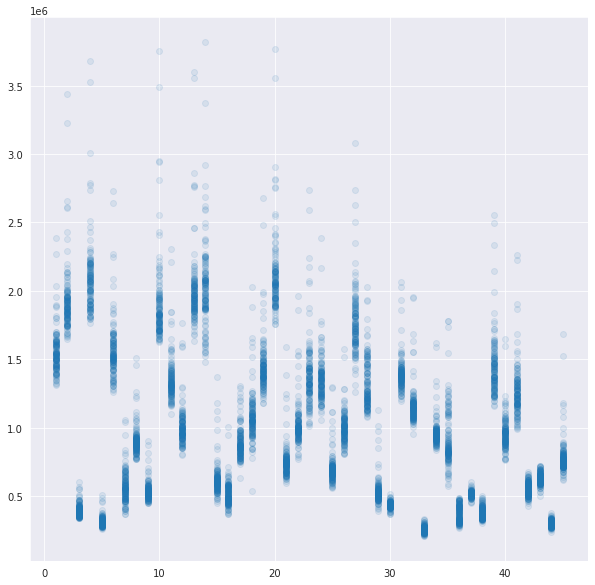

In [241]:
#Store별로 매출액 평균이 유의미한 분포를 갖고 있다. Store별로 outlier 제거 후 평균 

# train_df.plot(kind='line', x=range(len(train_df)), y="Weekly_Sales")
plt.figure(figsize=(10, 10))
plt.scatter(train_df['Store'], train_df['Weekly_Sales'], alpha=0.1)

#stroe name 과 매출액간의 상관관계 시각화

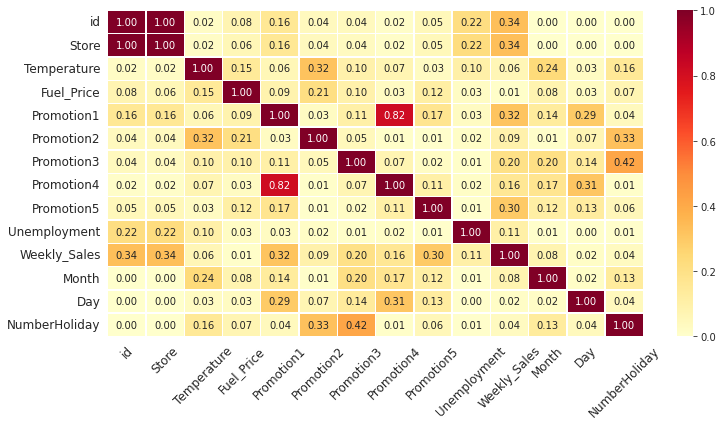

In [242]:
#각 특성 별 상관관계

fig, ax = plt.subplots(figsize=(12,6))

sns.heatmap(train_df.corr().abs(), # 위에서 전처리한 데이터프레임
            annot = True, # 숫자 표시 여부
            ax = ax, # 히트맵을 그릴 격자
            linewidths = 0.4, # 선의 굵기
            linecolor = 'white', # 선의 색깔
            fmt = '.2f', # 소수점 포맷팅 형태
            cmap = 'YlOrRd') # colormap 형태

plt.xticks(rotation=45, size = 12)
plt.yticks(size=12) 
plt.show()

In [243]:
#우선 promotion은 예측에 방해가 되는 요소인것 같아 제거하고 진행
train_df.drop(columns=['Promotion1','Promotion2','Promotion3','Promotion4','Promotion5'], inplace = True)
test_df.drop(columns=['Promotion1','Promotion2','Promotion3','Promotion4','Promotion5'], inplace = True)

train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

#Temperature과 Fuel을 범주형으로 나누어 판매액과 비교
def temfunc(temp):
  if temp<47 and temp>-5:
    return 0

  elif temp>=47 and temp<62:
    return 2

  elif temp>=62 and temp<75:
    return 1

  else:
    return 3

def fuelfunc(fuel):
  if fuel<2.917:
    return 2
  
  elif fuel>=2.917 and fuel<3.413:
    return 0
  
  elif fuel>=3.413:
    return 1

def unemplefunc(employ):
  if employ<6.9 and employ>1.8:
    return 1
  elif employ>=6.9 and employ<7.9:
    return 0
  elif employ>=7.9 and employ>8.6:
    return 1
  else:
    return 0

train_df['Tem_level']=train_df['Temperature'].apply(lambda x : temfunc(x))
test_df['Tem_level']=test_df['Temperature'].apply(lambda x : temfunc(x))

train_df['Fuel_level']=train_df['Fuel_Price'].apply(lambda x : fuelfunc(x))
test_df['Fuel_level']=test_df['Fuel_Price'].apply(lambda x : fuelfunc(x))

train_df['Unemp_level']=train_df['Unemployment'].apply(lambda x : unemplefunc(x))
test_df['Unemp_level']=test_df['Unemployment'].apply(lambda x : unemplefunc(x))

In [244]:
train_df.describe()

,id,Store,Temperature,Fuel_Price,Unemployment,Weekly_Sales,Month,Day,NumberHoliday,Tem_level,Fuel_level,Unemp_level
count,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6.255000e+03,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000
mean,3128.000000,23.000000,60.639199,3.344369,8.029236,1.047619e+06,6.345324,15.683453,0.071942,1.499920,0.998721,0.495124
std,1805.807299,12.988211,18.624094,0.455364,1.874875,5.654362e+05,3.227195,8.781023,0.258413,1.120909,0.706087,0.500016
min,1.000000,1.000000,-2.060000,2.472000,4.077000,2.099862e+05,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1564.500000,12.000000,47.170000,2.917000,6.916500,5.538695e+05,4.000000,8.000000,0.000000,1.000000,1.000000,0.000000
50%,3128.000000,23.000000,62.720000,3.413000,7.906000,9.604761e+05,6.000000,16.000000,0.000000,1.000000,1.000000,0.000000
75%,4691.500000,34.000000,75.220000,3.722000,8.622000,1.421209e+06,9.000000,23.000000,0.000000,3.000000,1.000000,1.000000
max,6255.000000,45.000000,100.140000,4.308000,14.313000,3.818686e+06,12.000000,31.000000,1.000000,3.000000,2.000000,1.000000


In [245]:
train_df['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [246]:
test_df['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [247]:
temp_mean=train_df[['Tem_level', 'Weekly_Sales']].groupby(['Tem_level']).mean()
fuel_mean=train_df[['Fuel_level', 'Weekly_Sales']].groupby(['Fuel_level']).mean()
emple_mean=train_df[['Unemp_level', 'Weekly_Sales']].groupby(['Unemp_level']).mean()
store_mean=train_df[['Store', 'Weekly_Sales']].groupby(['Store']).mean()
week_mean=train_df[['NumberHoliday', 'Weekly_Sales']].groupby(['NumberHoliday']).mean()

In [248]:
temp_mean

,Weekly_Sales
Tem_level,
0,1.095179e+06
1,1.060037e+06
2,1.047123e+06
3,9.891582e+05


In [249]:
fuel_mean

,Weekly_Sales
Fuel_level,
0,1.062881e+06
1,1.047631e+06
2,1.032255e+06


In [250]:
emple_mean

,Weekly_Sales
Unemp_level,
0,1.135030e+06
1,9.584867e+05


In [251]:
store_mean.head()

,Weekly_Sales
Store,
1,1.555088e+06
2,1.926625e+06
3,4.021757e+05
4,2.093196e+06
5,3.178013e+05


In [252]:
week_mean
# Counter(train_df['NumberHoliday'].values)

,Weekly_Sales
NumberHoliday,
0,1.041784e+06
1,1.122888e+06


In [253]:
tm = list(temp_mean['Weekly_Sales'].values)
fm = list(fuel_mean['Weekly_Sales'].values)
em = list(emple_mean['Weekly_Sales'].values)
sm = list(store_mean['Weekly_Sales'].values)
wm = list(week_mean['Weekly_Sales'].values)

In [254]:
# iris["new_columns"] = iris["sepal_length"].apply(lambda x : func(x))

train_df['Tem_mean']= train_df['Tem_level'].apply(lambda x: tm[x])
train_df['Fuel_mean']= train_df['Fuel_level'].apply(lambda x: fm[x])
train_df['Unemp_mean']= train_df['Unemp_level'].apply(lambda x: em[x])
train_df['Store_mean']= train_df['Store'].apply(lambda x : sm[x-1])
train_df['Week_mean']= train_df['NumberHoliday'].apply(lambda x : wm[x])


test_df['Tem_mean']= test_df['Tem_level'].apply(lambda x: tm[x])
test_df['Fuel_mean']= test_df['Fuel_level'].apply(lambda x: fm[x])
test_df['Unemp_mean']= test_df['Unemp_level'].apply(lambda x: em[x])
test_df['Store_mean']= test_df['Store'].apply(lambda x : sm[x-1])
test_df['Week_mean']= test_df['NumberHoliday'].apply(lambda x : wm[x])

In [255]:
train_df

,id,Store,Date,Temperature,Fuel_Price,Unemployment,Weekly_Sales,Date_new,Month,Day,NumberHoliday,Tem_level,Fuel_level,Unemp_level,Tem_mean,Fuel_mean,Unemp_mean,Store_mean,Week_mean
0,1,1,05/02/2010,42.31,2.572,8.106,1643690.90,2010/02/05,2,5,0,0,2,0,1.095179e+06,1.032255e+06,1.135030e+06,1.555088e+06,1.041784e+06
1,2,1,12/02/2010,38.51,2.548,8.106,1641957.44,2010/02/12,2,12,1,0,2,0,1.095179e+06,1.032255e+06,1.135030e+06,1.555088e+06,1.122888e+06
2,3,1,19/02/2010,39.93,2.514,8.106,1611968.17,2010/02/19,2,19,0,0,2,0,1.095179e+06,1.032255e+06,1.135030e+06,1.555088e+06,1.041784e+06
3,4,1,26/02/2010,46.63,2.561,8.106,1409727.59,2010/02/26,2,26,0,0,2,0,1.095179e+06,1.032255e+06,1.135030e+06,1.555088e+06,1.041784e+06
4,5,1,05/03/2010,46.50,2.625,8.106,1554806.68,2010/03/05,3,5,0,0,2,0,1.095179e+06,1.032255e+06,1.135030e+06,1.555088e+06,1.041784e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,31/08/2012,75.09,3.867,8.684,734297.87,2012/08/31,8,31,0,3,1,1,9.891582e+05,1.047631e+06,9.584867e+05,7.874030e+05,1.041784e+06
6251,6252,45,07/09/2012,75.70,3.911,8.684,766512.66,2012/09/07,9,7,1,3,1,1,9.891582e+05,1.047631e+06,9.584867e+05,7.874030e+05,1.122888e+06
6252,6253,45,14/09/2012,67.87,3.948,8.684,702238.27,2012/09/14,9,14,0,1,1,1,1.060037e+06,1.047631e+06,9.584867e+05,7.874030e+05,1.041784e+06
6253,6254,45,21/09/2012,65.32,4.038,8.684,723086.20,2012/09/21,9,21,0,1,1,1,1.060037e+06,1.047631e+06,9.584867e+05,7.874030e+05,1.041784e+06


In [256]:
month_mean=train_df[['Month', 'Weekly_Sales']].groupby(['Month']).mean()/10**5-train_df['Weekly_Sales'].mean()/10**5
day_mean=train_df[['Day', 'Weekly_Sales']].groupby(['Day']).mean()/10**5-train_df['Weekly_Sales'].mean()/10**5

In [257]:
month_mean.head(3)

,Weekly_Sales
Month,
1,-1.237345
2,0.055807
3,-0.343098


In [258]:
day_mean.head(3)

,Weekly_Sales
Day,
1,-0.389578
2,0.233566
3,0.165889


In [259]:
mm = list(month_mean['Weekly_Sales'].values)
dm = list(day_mean['Weekly_Sales'].values)

In [260]:
print(mm)
print(dm)
len(dm)

[-1.2373452245023984, 0.05580723318278835, -0.34309840854085927, -0.20857510366906418, -0.15905051681721183, 0.16705519077538078, -0.1587149087484292, 0.0039837716300823445, -0.5828372464895768, -0.5892004376196827, 0.9964682899420474, 2.34244559966427]
[-0.38957761144684255, 0.23356617255315903, 0.1658886983309351, 0.15056482677538163, 0.10267924299760267, 0.40281891121982305, -0.09725857366906432, -0.003919816446842361, 0.41579366855315847, 0.474198677442045, -0.023294620335731153, -0.10749939478017545, -0.4022958394468432, -0.7759342275579542, -0.3622550597801748, 0.2886416005531576, 0.6305024681087144, -0.05514824478017566, -0.18125183700239766, -0.5063853727801746, -0.7012875914468406, -0.21585418589128658, 0.8275174467753796, 1.1412694734420459, 0.5503498787753784, 0.7093916991087141, -0.7494295821135104, -0.6457420714468416, -0.6198990642246205, -0.616339893669064, -0.7437286903357307]


31

In [261]:
train_df['Month_mean']= train_df['Month'].apply(lambda x : mm[x-1])
train_df['Day_mean']= train_df['Day'].apply(lambda x : dm[x-1])


test_df['Month_mean']= test_df['Month'].apply(lambda x: mm[x-1])
test_df['Day_mean']= test_df['Day'].apply(lambda x: dm[x-1])

In [262]:
#전처리확인
train_df.head()

,id,Store,Date,Temperature,Fuel_Price,Unemployment,Weekly_Sales,Date_new,Month,Day,...,Tem_level,Fuel_level,Unemp_level,Tem_mean,Fuel_mean,Unemp_mean,Store_mean,Week_mean,Month_mean,Day_mean
0,1,1,05/02/2010,42.31,2.572,8.106,1643690.90,2010/02/05,2,5,...,0,2,0,1.095179e+06,1.032255e+06,1.135030e+06,1.555088e+06,1.041784e+06,0.055807,0.102679
1,2,1,12/02/2010,38.51,2.548,8.106,1641957.44,2010/02/12,2,12,...,0,2,0,1.095179e+06,1.032255e+06,1.135030e+06,1.555088e+06,1.122888e+06,0.055807,-0.107499
2,3,1,19/02/2010,39.93,2.514,8.106,1611968.17,2010/02/19,2,19,...,0,2,0,1.095179e+06,1.032255e+06,1.135030e+06,1.555088e+06,1.041784e+06,0.055807,-0.181252
3,4,1,26/02/2010,46.63,2.561,8.106,1409727.59,2010/02/26,2,26,...,0,2,0,1.095179e+06,1.032255e+06,1.135030e+06,1.555088e+06,1.041784e+06,0.055807,0.709392
4,5,1,05/03/2010,46.50,2.625,8.106,1554806.68,2010/03/05,3,5,...,0,2,0,1.095179e+06,1.032255e+06,1.135030e+06,1.555088e+06,1.041784e+06,-0.343098,0.102679


In [263]:
#전처리확인
test_df.head()

,id,Store,Date,Temperature,Fuel_Price,Unemployment,Date_new,Month,Day,NumberHoliday,Tem_level,Fuel_level,Unemp_level,Tem_mean,Fuel_mean,Unemp_mean,Store_mean,Week_mean,Month_mean,Day_mean
0,1,1,05/10/2012,68.55,3.617,6.573,2012/10/05,10,5,0,1,1,1,1.060037e+06,1.047631e+06,958486.731815,1.555088e+06,1.041784e+06,-0.5892,0.102679
1,2,1,12/10/2012,62.99,3.601,6.573,2012/10/12,10,12,0,1,1,1,1.060037e+06,1.047631e+06,958486.731815,1.555088e+06,1.041784e+06,-0.5892,-0.107499
2,3,1,19/10/2012,67.97,3.594,6.573,2012/10/19,10,19,0,1,1,1,1.060037e+06,1.047631e+06,958486.731815,1.555088e+06,1.041784e+06,-0.5892,-0.181252
3,4,1,26/10/2012,69.16,3.506,6.573,2012/10/26,10,26,0,1,1,1,1.060037e+06,1.047631e+06,958486.731815,1.555088e+06,1.041784e+06,-0.5892,0.709392
4,5,2,05/10/2012,70.27,3.617,6.170,2012/10/05,10,5,0,1,1,1,1.060037e+06,1.047631e+06,958486.731815,1.926625e+06,1.041784e+06,-0.5892,0.102679


In [264]:
train_columns_list = list(train_df.columns)
test_columns_list = list(test_df.columns)
print(train_columns_list)
print(test_columns_list)

['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Unemployment', 'Weekly_Sales', 'Date_new', 'Month', 'Day', 'NumberHoliday', 'Tem_level', 'Fuel_level', 'Unemp_level', 'Tem_mean', 'Fuel_mean', 'Unemp_mean', 'Store_mean', 'Week_mean', 'Month_mean', 'Day_mean']
['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Unemployment', 'Date_new', 'Month', 'Day', 'NumberHoliday', 'Tem_level', 'Fuel_level', 'Unemp_level', 'Tem_mean', 'Fuel_mean', 'Unemp_mean', 'Store_mean', 'Week_mean', 'Month_mean', 'Day_mean']


In [265]:
#필요없는 칼럼 제거 및 데이터 준비
target = train_df["Weekly_Sales"].to_numpy()

# train_df.drop(columns=train_columns_list[:14], inplace = True)
# test_df.drop(columns=test_columns_list[:13], inplace = True)
train_df.drop(columns=['id','Store','Date','Date_new','Month','Day','Weekly_Sales'], inplace=True)
test_df.drop(columns=['id','Store','Date','Date_new','Month','Day'], inplace=True)

train_columns_list = list(train_df.columns)
test_columns_list = list(test_df.columns)

print(train_columns_list)
print(test_columns_list)

['Temperature', 'Fuel_Price', 'Unemployment', 'NumberHoliday', 'Tem_level', 'Fuel_level', 'Unemp_level', 'Tem_mean', 'Fuel_mean', 'Unemp_mean', 'Store_mean', 'Week_mean', 'Month_mean', 'Day_mean']
['Temperature', 'Fuel_Price', 'Unemployment', 'NumberHoliday', 'Tem_level', 'Fuel_level', 'Unemp_level', 'Tem_mean', 'Fuel_mean', 'Unemp_mean', 'Store_mean', 'Week_mean', 'Month_mean', 'Day_mean']


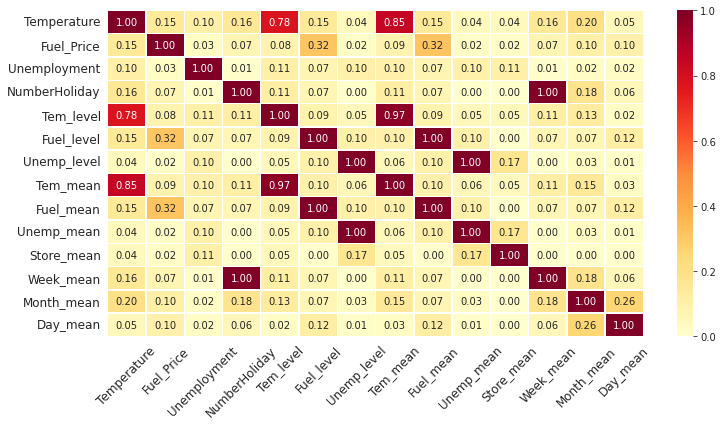

In [266]:
#각 특성 별 상관관계

fig, ax = plt.subplots(figsize=(12,6))

sns.heatmap(train_df.corr().abs(), # 위에서 전처리한 데이터프레임
            annot = True, # 숫자 표시 여부
            ax = ax, # 히트맵을 그릴 격자
            linewidths = 0.4, # 선의 굵기
            linecolor = 'white', # 선의 색깔
            fmt = '.2f', # 소수점 포맷팅 형태
            cmap = 'YlOrRd') # colormap 형태

plt.xticks(rotation=45, size = 12)
plt.yticks(size=12) 
plt.show()

In [267]:
train_df.describe()

,Temperature,Fuel_Price,Unemployment,NumberHoliday,Tem_level,Fuel_level,Unemp_level,Tem_mean,Fuel_mean,Unemp_mean,Store_mean,Week_mean,Month_mean,Day_mean
count,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03
mean,60.639199,3.344369,8.029236,0.071942,1.499920,0.998721,0.495124,1.047619e+06,1.047619e+06,1.047619e+06,1.047619e+06,1.047619e+06,7.923318e-16,2.811500e-16
std,18.624094,0.455364,1.874875,0.258413,1.120909,0.706087,0.500016,3.837539e+04,1.081250e+04,8.827436e+04,5.411910e+05,2.095825e+04,7.857201e-01,5.108698e-01
min,-2.060000,2.472000,4.077000,0.000000,0.000000,0.000000,0.000000,9.891582e+05,1.032255e+06,9.584867e+05,2.596752e+05,1.041784e+06,-1.237345e+00,-7.759342e-01
25%,47.170000,2.917000,6.916500,0.000000,1.000000,1.000000,0.000000,9.891582e+05,1.047631e+06,9.584867e+05,5.561442e+05,1.041784e+06,-3.430984e-01,-4.022958e-01
50%,62.720000,3.413000,7.906000,0.000000,1.000000,1.000000,0.000000,1.060037e+06,1.047631e+06,1.135030e+06,9.669910e+05,1.041784e+06,-1.587149e-01,-2.329462e-02
75%,75.220000,3.722000,8.622000,0.000000,3.000000,1.000000,1.000000,1.060037e+06,1.047631e+06,1.135030e+06,1.396622e+06,1.041784e+06,5.580723e-02,4.028189e-01
max,100.140000,4.308000,14.313000,1.000000,3.000000,2.000000,1.000000,1.095179e+06,1.062881e+06,1.135030e+06,2.107607e+06,1.122888e+06,2.342446e+00,1.141269e+00


In [300]:
train = train_df[train_columns_list].to_numpy()
sub_input = test_df[test_columns_list].to_numpy()
train_input, test_input, train_target, test_target = train_test_split(train, target, test_size=0.2, shuffle=True, random_state=42)

In [301]:
train_input

array([[ 7.74600000e+01,  3.66600000e+00,  6.33400000e+00, ...,
         1.04178428e+06, -5.82837246e-01, -6.45742071e-01],
       [ 3.55900000e+01,  2.96100000e+00,  5.28700000e+00, ...,
         1.04178428e+06,  9.96468290e-01, -1.07499395e-01],
       [ 5.31100000e+01,  2.90800000e+00,  8.10700000e+00, ...,
         1.04178428e+06, -1.59050517e-01, -6.45742071e-01],
       ...,
       [ 8.80000000e+01,  3.91300000e+00,  1.35030000e+01, ...,
         1.12288789e+06, -5.82837246e-01,  4.15793669e-01],
       [ 6.40500000e+01,  3.63000000e+00,  7.24400000e+00, ...,
         1.04178428e+06, -3.43098409e-01,  2.33566173e-01],
       [ 6.17000000e+01,  2.69000000e+00,  9.01700000e+00, ...,
         1.04178428e+06,  3.98377163e-03,  4.02818911e-01]])

In [302]:
sub_input

array([[ 6.85500000e+01,  3.61700000e+00,  6.57300000e+00, ...,
         1.04178428e+06, -5.89200438e-01,  1.02679243e-01],
       [ 6.29900000e+01,  3.60100000e+00,  6.57300000e+00, ...,
         1.04178428e+06, -5.89200438e-01, -1.07499395e-01],
       [ 6.79700000e+01,  3.59400000e+00,  6.57300000e+00, ...,
         1.04178428e+06, -5.89200438e-01, -1.81251837e-01],
       ...,
       [ 5.44700000e+01,  4.00000000e+00,  8.66700000e+00, ...,
         1.04178428e+06, -5.89200438e-01, -1.07499395e-01],
       [ 5.64700000e+01,  3.96900000e+00,  8.66700000e+00, ...,
         1.04178428e+06, -5.89200438e-01, -1.81251837e-01],
       [ 5.88500000e+01,  3.88200000e+00,  8.66700000e+00, ...,
         1.04178428e+06, -5.89200438e-01,  7.09391699e-01]])

# 데이터 준비 및 훈련 파트

In [303]:
# ss = StandardScaler()
# ss.fit(train_input)
# train_input = ss.transform(train_input)
# test_input = ss.transform(test_input)
# sub_input =ss.transform(sub_input)

lr = LinearRegression()
lr.fit(train_input, train_target)
print(lr.score(test_input, test_target))
print(lr.score(train_input, train_target))

0.9345063471813617
0.9406790350217248


In [304]:
RMSE = mean_squared_error(lr.predict(test_input), test_target)**0.5
def rmse(array_target, array_pred):
  return mean_squared_error(array_target, array_pred)**0.5

test_pred = lr.predict(test_input)

print(rmse(test_target, test_pred))

147858.38531291587


In [305]:
test_df.describe()


,Temperature,Fuel_Price,Unemployment,NumberHoliday,Tem_level,Fuel_level,Unemp_level,Tem_mean,Fuel_mean,Unemp_mean,Store_mean,Week_mean,Month_mean,Day_mean
count,180.000000,180.000000,180.000000,180.0,180.000000,180.0,180.000000,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,180.0000,180.000000
mean,61.518056,3.853361,6.953711,0.0,1.427778,1.0,0.733333,1.054232e+06,1.047631e+06,1.005565e+06,1.047619e+06,1.041784e+06,-0.5892,0.130830
std,10.455740,0.274645,1.593834,0.0,0.747663,0.0,0.443450,2.099621e+04,1.167401e-10,7.828802e+04,5.426572e+05,1.167401e-10,0.0000,0.350877
min,39.380000,3.494000,3.879000,0.0,0.000000,1.0,0.000000,9.891582e+05,1.047631e+06,9.584867e+05,2.596752e+05,1.041784e+06,-0.5892,-0.181252
25%,54.180000,3.601000,6.034000,0.0,1.000000,1.0,0.000000,1.047123e+06,1.047631e+06,9.584867e+05,5.561442e+05,1.041784e+06,-0.5892,-0.125938
50%,61.530000,3.789000,6.895000,0.0,1.000000,1.0,1.000000,1.060037e+06,1.047631e+06,9.584867e+05,9.669910e+05,1.041784e+06,-0.5892,-0.002410
75%,70.357500,4.027000,8.000000,0.0,2.000000,1.0,1.000000,1.060037e+06,1.047631e+06,1.135030e+06,1.396622e+06,1.041784e+06,-0.5892,0.254357
max,85.180000,4.468000,10.199000,0.0,3.000000,1.0,1.000000,1.095179e+06,1.047631e+06,1.135030e+06,2.107607e+06,1.041784e+06,-0.5892,0.709392


In [306]:
target

array([1643690.9 , 1641957.44, 1611968.17, ...,  702238.27,  723086.2 ,
        713173.95])

In [307]:
train_df.describe()

,Temperature,Fuel_Price,Unemployment,NumberHoliday,Tem_level,Fuel_level,Unemp_level,Tem_mean,Fuel_mean,Unemp_mean,Store_mean,Week_mean,Month_mean,Day_mean
count,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03,6.255000e+03
mean,60.639199,3.344369,8.029236,0.071942,1.499920,0.998721,0.495124,1.047619e+06,1.047619e+06,1.047619e+06,1.047619e+06,1.047619e+06,7.923318e-16,2.811500e-16
std,18.624094,0.455364,1.874875,0.258413,1.120909,0.706087,0.500016,3.837539e+04,1.081250e+04,8.827436e+04,5.411910e+05,2.095825e+04,7.857201e-01,5.108698e-01
min,-2.060000,2.472000,4.077000,0.000000,0.000000,0.000000,0.000000,9.891582e+05,1.032255e+06,9.584867e+05,2.596752e+05,1.041784e+06,-1.237345e+00,-7.759342e-01
25%,47.170000,2.917000,6.916500,0.000000,1.000000,1.000000,0.000000,9.891582e+05,1.047631e+06,9.584867e+05,5.561442e+05,1.041784e+06,-3.430984e-01,-4.022958e-01
50%,62.720000,3.413000,7.906000,0.000000,1.000000,1.000000,0.000000,1.060037e+06,1.047631e+06,1.135030e+06,9.669910e+05,1.041784e+06,-1.587149e-01,-2.329462e-02
75%,75.220000,3.722000,8.622000,0.000000,3.000000,1.000000,1.000000,1.060037e+06,1.047631e+06,1.135030e+06,1.396622e+06,1.041784e+06,5.580723e-02,4.028189e-01
max,100.140000,4.308000,14.313000,1.000000,3.000000,2.000000,1.000000,1.095179e+06,1.062881e+06,1.135030e+06,2.107607e+06,1.122888e+06,2.342446e+00,1.141269e+00


In [308]:
sub_input.shape

(180, 14)

In [311]:
submit.head()

,id,Weekly_Sales
0,1,1.531200e+06
1,2,1.511735e+06
2,3,1.512452e+06
3,4,1.570359e+06
4,5,1.904993e+06


In [313]:
# 예측된 값을 정답파일과 병합
prediction = lr.predict(sub_input)
submit['Weekly_Sales'] = prediction

# 정답파일 데이터프레임 확인
submit.head()
submit.to_csv('sub003_model_lr_0715_final.csv',index = False)

In [312]:
prediction

array([1531199.63386177, 1511734.54130071, 1512451.82047879,
       1570358.67155234, 1904992.97360261, 1885274.66206681,
       1884491.49001023, 1942964.74388434,  387434.81858369,
        371379.0351875 ,  370081.22747899,  428020.75563719,
       2070700.94839014, 2054619.33479355, 2054116.49086853,
       2109823.17072537,  303531.87735488,  284753.00357141,
        283237.34863193,  342603.77615306, 1550285.64421937,
       1530983.93708155, 1530906.07386654, 1590414.10208781,
        515551.1759711 ,  507475.84251662,  504485.6663135 ,
        560605.91264445,  886734.68123685,  866376.41502877,
        866519.09370386,  925035.91702417,  525113.35695287,
        508423.12192771,  508522.2311566 ,  566777.63779973,
       1843701.97331992, 1825485.72642473, 1851263.68937421,
       1905386.08843088, 1341824.63402815, 1324679.61447704,
       1324144.27207697, 1381288.6578421 ,  956681.01607689,
        967338.59317549,  959260.41912697, 1012838.20010619,
       1977847.22863991,

In [314]:
lr.predict(test_input)

array([1400075.8328385 , 1966701.20394281,  373985.05885264, ...,
        777821.56823681,  483888.73126553, 1060095.50413087])

In [315]:
train_df.head(1)

,Temperature,Fuel_Price,Unemployment,NumberHoliday,Tem_level,Fuel_level,Unemp_level,Tem_mean,Fuel_mean,Unemp_mean,Store_mean,Week_mean,Month_mean,Day_mean
0,42.31,2.572,8.106,0,0,2,0,1.095179e+06,1.032255e+06,1.135030e+06,1.555088e+06,1.041784e+06,0.055807,0.102679


In [316]:
for i in train_input:
  print(i)
  break

[ 7.74600000e+01  3.66600000e+00  6.33400000e+00  0.00000000e+00
  3.00000000e+00  1.00000000e+00  1.00000000e+00  9.89158162e+05
  1.04763094e+06  9.58486732e+05  4.02175736e+05  1.04178428e+06
 -5.82837246e-01 -6.45742071e-01]


In [317]:
for i in sub_input:
  print(i)
  break

[ 6.85500000e+01  3.61700000e+00  6.57300000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.06003691e+06
  1.04763094e+06  9.58486732e+05  1.55508792e+06  1.04178428e+06
 -5.89200438e-01  1.02679243e-01]


id : 샘플 아이디

Store : 쇼핑몰 지점

Date : 주 단위(Weekly) 날짜

Temperature : 해당 쇼핑몰 주변 기온

Fuel_Price : 해당 쇼핑몰 주변 연료 가격

Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보

Unemployment : 해당 쇼핑몰 지역의 실업률

IsHoliday : 해당 기간의 공휴일 포함 여부

Weekly_Sales : 주간 매출액 (목표 예측값)
